# How does Twitter discuss trans people?

We have searched for the following terms:
- trans people
- transgender

In [1]:
import pandas as pd

from utils.df_imports import read_jsonl_gz

PATHS = [
    '../data/search_trans_people.jsonl.gz',
    '../data/search_transgender.jsonl.gz'
]

raw_tweet_df = pd.concat([read_jsonl_gz(path) for path in PATHS])
raw_tweet_df.drop_duplicates('id', inplace=True)

raw_tweet_df

,tweet,author,date,id
0,RT @AriDrennen: 🚨The Texas Senate just approve...,Chococoder,2021-04-28 03:05:19,1387241491169480707
1,RT @zoewhittall: What @TheCurrentCBC is ignori...,sexisnonbinary,2021-04-28 03:05:03,1387241423293108236
2,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,2021-04-28 03:05:01,1387241412576505857
3,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,2021-04-28 03:05:01,1387241412329095179
4,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,2021-04-28 03:04:58,1387241400371089408
...,...,...,...,...
150088,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,2021-04-19 21:32:25,1384258608544686087
150089,Activists sue to keep number of transgender in...,debbies3360,2021-04-19 21:32:19,1384258583462772742
150090,John Bel Edwards won't support bills that ban ...,DarthDandious,2021-04-19 21:32:14,1384258562675806216
150091,local transgender makes 'love' on personal grass,localwebwebs,2021-04-19 21:31:26,1384258360199979010


## Preliminary Data Cleaning Steps

In [2]:
tweet_df: pd.DataFrame = raw_tweet_df
tweet_df['i'] = tweet_df.index  # Add the original integer index as a column
#tweet_df = tweet_df[~tweet_df['tweet'].str.startswith('RT @')]  # remove retweets?
tweet_df

,tweet,author,date,id,i
0,RT @AriDrennen: 🚨The Texas Senate just approve...,Chococoder,2021-04-28 03:05:19,1387241491169480707,0
1,RT @zoewhittall: What @TheCurrentCBC is ignori...,sexisnonbinary,2021-04-28 03:05:03,1387241423293108236,1
2,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,2021-04-28 03:05:01,1387241412576505857,2
3,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,2021-04-28 03:05:01,1387241412329095179,3
4,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,2021-04-28 03:04:58,1387241400371089408,4
...,...,...,...,...,...
150088,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,2021-04-19 21:32:25,1384258608544686087,150088
150089,Activists sue to keep number of transgender in...,debbies3360,2021-04-19 21:32:19,1384258583462772742,150089
150090,John Bel Edwards won't support bills that ban ...,DarthDandious,2021-04-19 21:32:14,1384258562675806216,150090
150091,local transgender makes 'love' on personal grass,localwebwebs,2021-04-19 21:31:26,1384258360199979010,150091


## N-gram hits

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/astrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


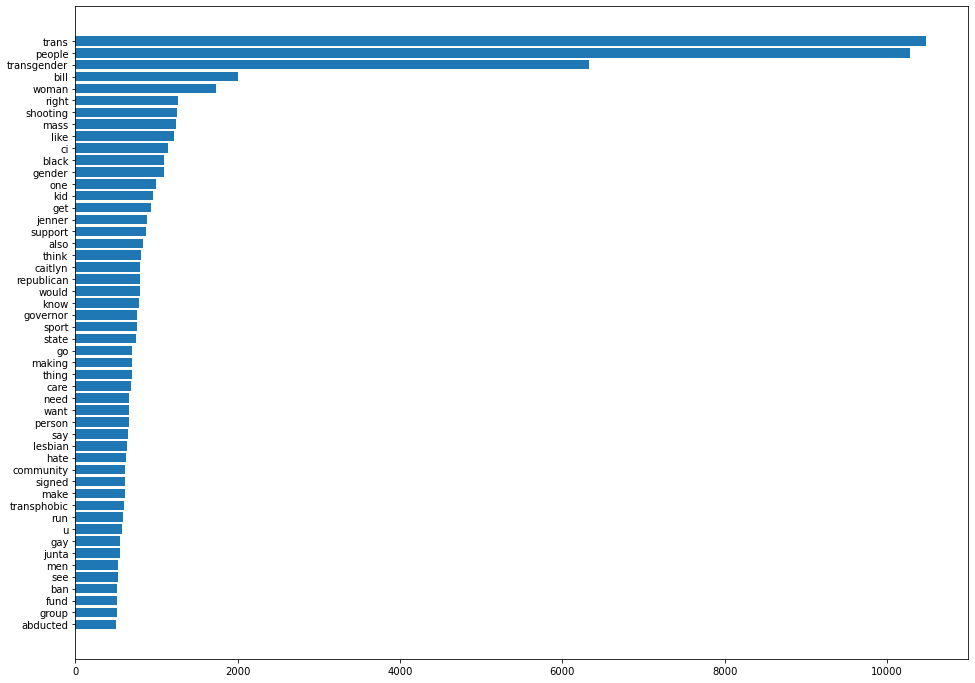

In [3]:
from utils.tokens import build_stopword_set, plot_ngrams
import matplotlib.pyplot as plt

stop = build_stopword_set()

_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=1)
plt.show()

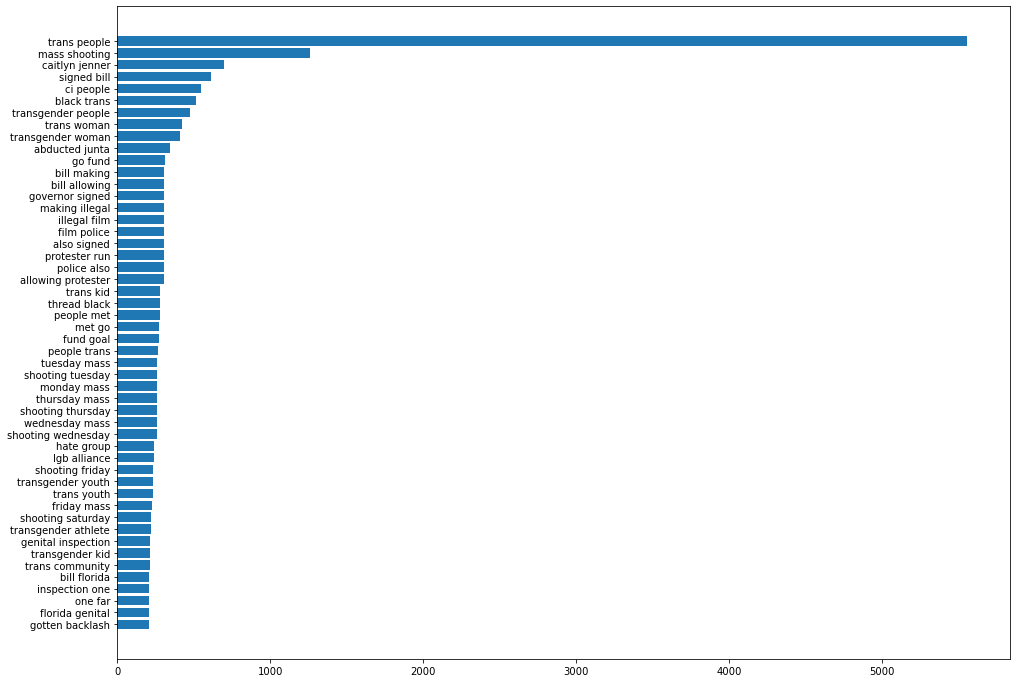

In [4]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=2)
plt.show()

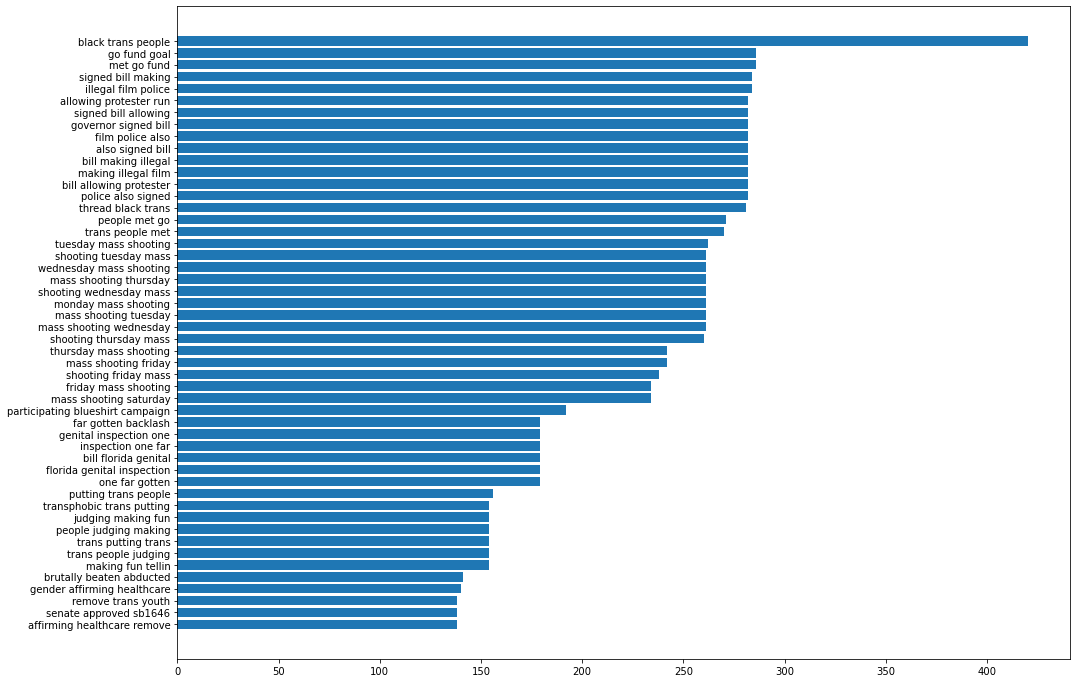

In [5]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=3)
plt.show()

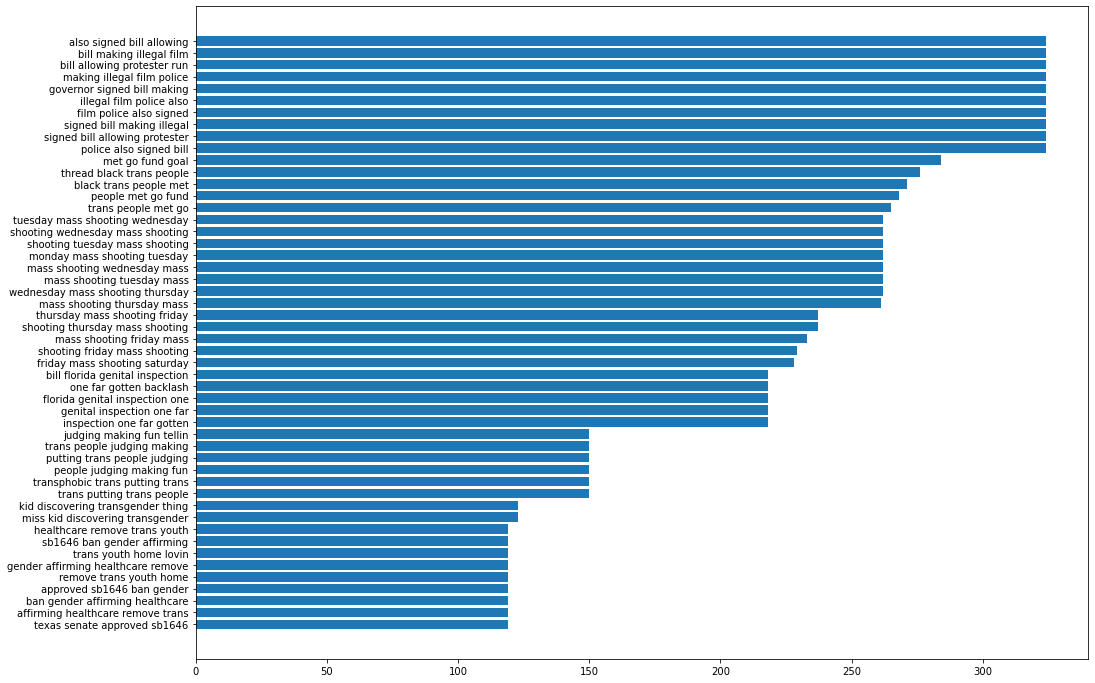

In [6]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=4)
plt.show()

### Interesting notes

1. There is mention of the Myanmar coup, which attacked and abducted Mingalar Taungnyunt, a trans woman protestor (`transgender abducted junta` with 270 hits)
2. A mass shooting on Thursday performed by a trans man (250 ish hits)
3. Caitlyn Jenner running for governor (`caitlyn jenner` with ~750 hits)
4. BLM riots? There seems to be a very-retweeted tweet, which listed bills in Georgia that got signed by the Governor. One of them was an anti-trans bill, the other was a running-over-protestors bill.
5. `@boostingtpoc thread black` trans people who have not met their go fund me goals
6. Various bills where republicans attack trans people in women's sports
    - `florida genital inspection` with 250 hits
    - `texas senate approved sb1646` with 150 hits
    - Non-trans, but also Republican bills get included in these mentions (i.e. illegal to film police, the running over protestors bill)
7. Something about judging trans people (170 hits)
8. Mentions of kids "discovering this transgender thing" (150 hits)

Let's go with **15** LDA topics.

## LDA Time

### Build dictionary and train TF-IDF

In [7]:
import utils.tokens as ut
import logging
import os
import gensim

TFIDF_MODEL_PATH = '../models/tfidf.model'
# Enable logging
# logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s', level=logging.INFO)

ranged_df = tweet_df
documents = list(ut.tokenize_tweets(ranged_df['tweet'], stop))
dictionary = gensim.corpora.Dictionary(documents)

bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

if os.path.exists(TFIDF_MODEL_PATH):
    tfidf = gensim.models.TfidfModel.load(TFIDF_MODEL_PATH)
else:
    tfidf = gensim.models.TfidfModel(bow_corpus)
    tfidf.save(TFIDF_MODEL_PATH)
corpus_tfidf = tfidf[bow_corpus]

### Train the LDA model

This takes a while because we have 300k tweets. Let's do it on a smaller sample of them.

In [8]:
import random

TOPICS = 15
LDA_TFIDF_MODEL_PATH = '../models/lda_tfidf.model'

lda_sample = random.choices(corpus_tfidf, k=50_000)

def train_lda(store_path, sample, n_topics):
    if os.path.exists(store_path):
        lda_model_tfidf = gensim.models.LdaMulticore.load(store_path)
    else:
        lda_model_tfidf = gensim.models.LdaMulticore(
            sample,
            num_topics=n_topics,
            id2word=dictionary,
            passes=10,
            workers=8
        )
        lda_model_tfidf.save(store_path)
    return lda_model_tfidf

lda_model_tfidf = train_lda(LDA_TFIDF_MODEL_PATH, lda_sample, TOPICS)

### Topics and words

In [9]:
for idx, topic in lda_model_tfidf.print_topics(-1, num_words=20):
    print('{}\t{}'.format(idx, topic))

0	0.005*"would" + 0.005*"veto" + 0.005*"allowed" + 0.004*"rule" + 0.004*"sport" + 0.004*"transgender" + 0.004*"bill" + 0.004*"people" + 0.003*"homeless" + 0.003*"kansa" + 0.003*"right" + 0.003*"urban" + 0.003*"housing" + 0.003*"trans" + 0.003*"development" + 0.003*"lgbtq" + 0.003*"athlete" + 0.003*"ban" + 0.003*"governor" + 0.003*"north"
1	0.007*"transgender" + 0.006*"bill" + 0.005*"lesbian" + 0.005*"state" + 0.005*"trans" + 0.005*"youth" + 0.005*"people" + 0.004*"kid" + 0.004*"right" + 0.004*"woman" + 0.004*"parent" + 0.004*"gop" + 0.003*"threat" + 0.003*"@aclu" + 0.003*"get" + 0.003*"death" + 0.003*"fight" + 0.003*"loom" + 0.003*"receiving" + 0.003*"testified"
2	0.009*"care" + 0.005*"view" + 0.005*"real" + 0.005*"support" + 0.005*"asinine" + 0.005*"@cmclymer" + 0.005*"way" + 0.005*"wil" + 0.005*"candidacy" + 0.005*"people" + 0.004*"trans" + 0.004*"caitlyn" + 0.003*"jenner" + 0.003*"seorang" + 0.003*"ulama" + 0.003*"woman" + 0.002*"transgender" + 0.002*"many" + 0.002*"u" + 0.002*"kid"

### Topic Identification

#### Terms related to the state anti-trans bills

In [10]:
def sum_of_scores(tweets):
    bows = [bow_corpus[i] for i in tweets]
    topic_scores = [0 for _ in range(TOPICS)]

    for tweet_topics in lda_model_tfidf[bows]:
        for idx, score in tweet_topics:
            topic_scores[idx] += score
    return topic_scores


def sort_and_print_topics(topic_scores):
    topics = list(enumerate(topic_scores))
    topics.sort(key=lambda pair: pair[1], reverse=True)
    return topics


def tweets_containing_term(term):
    return tweet_df[tweet_df['tweet'].str.lower().str.find(term) > 0]['i']


sort_and_print_topics(sum_of_scores(tweets_containing_term('senat')))  # to include senate, senator

[(11, 1935.7275699451566),
 (10, 373.43272361997515),
 (1, 215.28263677097857),
 (8, 133.89488247036934),
 (12, 126.40935395658016),
 (9, 121.08148638624698),
 (2, 92.68753398302943),
 (0, 92.66127937007695),
 (7, 91.24642499629408),
 (5, 90.73301995359361),
 (14, 88.53256966080517),
 (6, 69.01060387771577),
 (3, 58.24509696662426),
 (13, 57.14954420179129),
 (4, 36.01232686731964)]

In [11]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('sport')))

[(10, 2153.5095640476793),
 (11, 1168.612774468027),
 (1, 1152.387279016897),
 (8, 967.133436257951),
 (12, 654.5553995389491),
 (0, 627.8972454788163),
 (9, 571.0646624229848),
 (5, 557.2617471730337),
 (2, 534.6190194254741),
 (7, 530.399290359579),
 (6, 424.90981981903315),
 (14, 383.4906416591257),
 (3, 333.5607996042818),
 (13, 288.73801619000733),
 (4, 234.2129380106926)]

#### Terms related to Myanmar

In [12]:
#tweets = tweets_containing_term('myanmar')
#lda_model_tfidf.top_topics([bow_corpus[i] for i in tweets])


In [13]:
tweets = tweets_containing_term('florida')
topics = pd.DataFrame([lda_model_tfidf.get_document_topics(bow_corpus[i])[0] for i in tweets])

In [14]:
probabilities = topics.groupby(0).mean()
#topics.plot.bar()

<AxesSubplot:xlabel='0'>

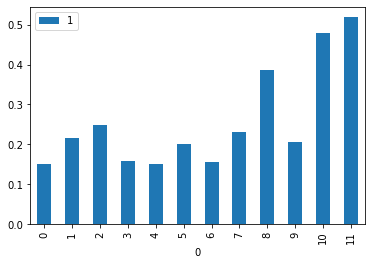

In [15]:
probabilities.plot.bar()

#### Caitlyn Jenner

In [16]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('caitlyn')))

[(11, 2233.409908371046),
 (10, 1914.9371790047735),
 (1, 1536.9365961179137),
 (2, 1491.0060506910086),
 (5, 1133.0796845722944),
 (9, 1054.5629149544984),
 (8, 974.6565674636513),
 (0, 775.8890083562583),
 (12, 543.714866572991),
 (13, 491.00874075386673),
 (7, 485.83605709671974),
 (6, 404.184058368206),
 (14, 336.2841227762401),
 (3, 304.30461787059903),
 (4, 151.11862155422568)]

In [17]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('jenner')))

[(11, 2501.21046126727),
 (10, 2393.1825021505356),
 (1, 2071.232251243666),
 (2, 1559.3475271752104),
 (8, 1284.2776918737218),
 (5, 1270.913156493567),
 (9, 1186.653408321552),
 (0, 898.3294108659029),
 (12, 843.8219951763749),
 (7, 596.5113496007398),
 (13, 551.3162769293413),
 (6, 496.58324810583144),
 (14, 404.16979357320815),
 (3, 394.77692125272006),
 (4, 206.35758490208536)]

In [18]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('governor')))

[(10, 1983.4549728762358),
 (1, 1191.0757088307291),
 (8, 1185.754200794734),
 (11, 1089.227496468462),
 (9, 660.5513261072338),
 (5, 635.4793358324096),
 (2, 605.5086588552222),
 (12, 583.1472882116213),
 (0, 556.1533892108127),
 (6, 524.7273822482675),
 (7, 499.9615009985864),
 (14, 421.54153979290277),
 (3, 321.7185690747574),
 (13, 299.0124486461282),
 (4, 234.77989435382187)]

## Cool visualization time!

We'll make a heatmap of what topics are most common at what times. First, we'll reindex the tweets by date.

In [19]:
tweet_time_df = tweet_df.set_index('date')
tweet_time_df.sort_index(inplace=True)
tweet_time_df

,tweet,author,id,i
date,,,,
2021-04-19 21:31:08,"RT @Perletear: @sallyrugg Black women, inferti...",CheNirvana,1384258285826547720,150092
2021-04-19 21:31:26,local transgender makes 'love' on personal grass,localwebwebs,1384258360199979010,150091
2021-04-19 21:32:14,John Bel Edwards won't support bills that ban ...,DarthDandious,1384258562675806216,150090
2021-04-19 21:32:19,Activists sue to keep number of transgender in...,debbies3360,1384258583462772742,150089
2021-04-19 21:32:25,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,1384258608544686087,150088
...,...,...,...,...
2021-04-28 03:04:58,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,1387241400371089408,4
2021-04-28 03:05:01,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,1387241412329095179,3
2021-04-28 03:05:01,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,1387241412576505857,2


Next, we'll group by date periods, aggregating everything into a sum of topic scores.

In [20]:
def agg_topics(group):
    return sum_of_scores(group.sample(2000))


chunked_scores = tweet_time_df['i'].resample('6H').agg(agg_topics)
chunked_scores

date
2021-04-19 18:00:00    [117.03003799915314, 191.17269007116556, 180.4...
2021-04-20 00:00:00    [116.56112721376121, 209.77996876928955, 102.0...
2021-04-20 06:00:00    [105.4223696840927, 186.83248382806778, 136.26...
2021-04-20 12:00:00    [107.50681919790804, 190.66088369581848, 131.8...
2021-04-20 18:00:00    [80.9041816983372, 185.14556946791708, 109.290...
2021-04-21 00:00:00    [78.64908670727164, 220.06134582404047, 103.54...
2021-04-21 06:00:00    [105.47786860819906, 270.9088371405378, 94.858...
2021-04-21 12:00:00    [86.78954866994172, 257.92703950963914, 87.541...
2021-04-21 18:00:00    [88.06077034398913, 213.30832411441952, 68.351...
2021-04-22 00:00:00    [86.96684362366796, 194.54961208440363, 64.391...
2021-04-22 06:00:00    [101.45693233329803, 162.03798233438283, 53.69...
2021-04-22 12:00:00    [95.68288981262594, 161.05641416832805, 83.193...
2021-04-22 18:00:00    [99.4709423435852, 183.50736256316304, 126.190...
2021-04-23 00:00:00    [117.47651886567473, 17

Finally, here is the plot.

AttributeError: 'str' object has no attribute 'print_topics'

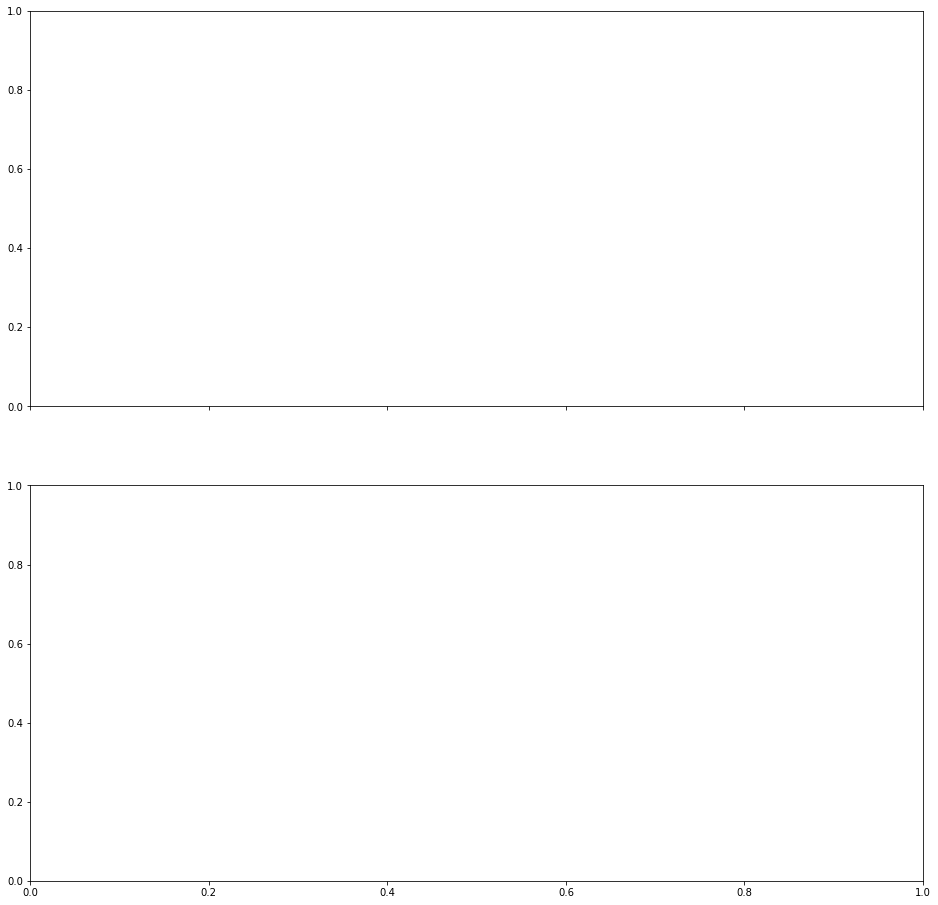

In [21]:
import numpy as np

# becomes indexed in (time, topic score)
def plot_prominence_heatmap(ax, indices, lda_model=lda_model_tfidf):
    chunked_scores = indices.resample('6H').agg(agg_topics)
    topics_over_time = np.array(list(chunked_scores)).T
    _, topics_n = topics_over_time.shape
    time_normalized_topic_prominence = topics_over_time / topics_over_time.sum(axis=0, keepdims=True)  # normalize by time

    yticks = [f'({i}) {words}' for i, words in lda_model.print_topics(-1, num_words=3)]

    ax.set_title('Topic Dominance over Time')
    ax.set_xlabel('Time Periods')
    ax.set_ylabel('Topic')
    ax.set_yticks(list(range(len(yticks))))  # show every topic
    ax.set_yticklabels(yticks)
    return ax.imshow(time_normalized_topic_prominence), topics_over_time

fig, (ax_total, ax_heatmap) = plt.subplots(2, 1, figsize=(16, 16), sharex=True)

mappable, topics_over_time = plot_prominence_heatmap(ax_heatmap, tweet_time_df['i'], '12H')
plt.colorbar(mappable)

ax_total.set_title('Total discussion about Transgender Issues')
ax_total.plot(topics_over_time.sum(axis=0))

plt.show()

### Sub-LDA's

Let's perform LDA on topic 8.

First, categorize tweets into topics.

In [ ]:
def get_topics_of_tweets(tweets):
    bows = [bow_corpus[i] for i in tweets]
    tweet_to_topic = np.empty_like(tweets)

    for tweet_i, tweet_topics in enumerate(lda_model_tfidf[bows]):
        topic_idx, _ = max(tweet_topics, key=lambda x: x[1])
        tweet_to_topic[tweet_i] = topic_idx

    return tweet_to_topic

tweet_to_topic = get_topics_of_tweets(tweet_time_df['i'])

In [ ]:
def get_tweets_under_topic(topic_i):
    return tweet_time_df['i'].iloc[np.nonzero(tweet_to_topic == topic_i)]

get_tweets_under_topic(3)

In [ ]:
sub_lda_sample = [corpus_tfidf[i] for i in get_tweets_under_topic(8)]
sub_lda_8 = train_lda('../models/sub_lda_8.model', sub_lda_sample, 5)

The original topic was:
```
0.005*"trans" + 0.005*"people" + 0.004*"ci" + 0.004*"stop" + 0.004*"transgender" + 0.003*"woman" + 0.003*"person" + 0.003*"female" + 0.003*"doctor" + 0.003*"go" + 0.002*"sex" + 0.002*"@skynews" + 0.002*"biden" + 0.002*"need" + 0.002*"playing" + 0.002*"like" + 0.002*"girl" + 0.002*"surgery" + 0.002*"character" + 0.002*"make"
```

In [ ]:
sub_lda_8.print_topics(num_words=20)

## Classifying, somehow?

Let's run [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) on these tweets. Can we separate tweets or users into pro- and anti- trans?

In [ ]:
from nltk import TweetTokenizer

# Get rid of handles
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)


def tokenize_preserve_grammar(tweet):
    return tokenizer.tokenize(tweet)


tweet_docs = [tokenize_preserve_grammar(tweet) for tweet in tweet_df['tweet']]

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

DOC2VEC_PATH = '../models/doc2vec.model'
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tweet_docs)]

if os.path.exists(DOC2VEC_PATH):
    model = Doc2Vec.load(DOC2VEC_PATH)
else:
    model = Doc2Vec(
        documents,
        vector_size=50,
        window=2,
        min_count=1,
        workers=8,
        epochs=50,
        compute_loss=True
    )
    model.save(DOC2VEC_PATH)

In [ ]:
sample_tweet = tweet_df.iloc[78889]
tokenized_sample = tweet_docs[sample_tweet['i']]
sample_vector = model.infer_vector(tokenized_sample)
print('Tweet: ', sample_tweet['tweet'].replace('\n', ' | '))

for index, similarity in model.docvecs.most_similar([sample_vector]):
    other_tweet = tweet_df.iloc[index]['tweet'].replace('\n', ' |   ')
    print(f'{similarity * 100:.1f}% {other_tweet}')

## Why do people support or oppose trans people?

[Multi aspect sentiment analysis](https://www.cs.cornell.edu/home/cardie/papers/masa-sentire-2011.pdf)

[Unsupervised sentiment analysis](https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483)

Their pipeline was:

1. Gather Polish Language dataset
2. Clean the dataset
3. Perform Word2Vec
4. K-Means clustering, for k=2
5. Identify which cluster is vaguely positive and vaguely negative, then take cosine distance between the centroids to each word for the positivity/negativity
6. Perform TF-IDF as a means of weighting each word's importance?